In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score


c:\Users\javie\OneDrive\Escritorio\prueba123\PruebaSerieTemp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./data/bank-full.csv', sep=';')
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
dummies = df.copy()
dummies = pd.get_dummies(df, columns=['poutcome', 'month', 'contact', 'loan', 'housing', 'default', 'education', 'marital', 'job'], drop_first=True)
dummies

,age,balance,day,duration,campaign,pdays,previous,y,poutcome_other,poutcome_success,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,2143,5,261,1,-1,0,no,False,False,...,False,False,True,False,False,False,False,False,False,False
1,44,29,5,151,1,-1,0,no,False,False,...,False,False,False,False,False,False,False,True,False,False
2,33,2,5,76,1,-1,0,no,False,False,...,True,False,False,False,False,False,False,False,False,False
3,47,1506,5,92,1,-1,0,no,False,False,...,False,False,False,False,False,False,False,False,False,False
4,33,1,5,198,1,-1,0,no,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0,yes,False,False,...,False,False,False,False,False,False,False,True,False,False
45207,71,1729,17,456,2,-1,0,yes,False,False,...,False,False,False,True,False,False,False,False,False,False
45208,72,5715,17,1127,5,184,3,yes,False,True,...,False,False,False,True,False,False,False,False,False,False
45209,57,668,17,508,4,-1,0,no,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
y = dummies['y']
X = dummies.drop(['y'], axis = 1)
print(f'El tamaño del dataset es de: {X.shape}')

El tamaño del dataset es de: (45211, 42)


In [6]:
std = StandardScaler()
vars_scale = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categoric = list(set(X.columns) - set(vars_scale))
X_var_scaled = std.fit_transform(X[vars_scale])
X_var_scaled = pd.DataFrame(X_var_scaled, columns = vars_scale, index = X.index)
X_var_scaled_full = pd.concat([X_var_scaled, X[categoric]], axis = 1)
print(f'El tamaño del dataset es de: {X_var_scaled_full.shape}')

El tamaño del dataset es de: (45211, 42)


# DBSCAN

In [7]:
eps_values = [5, 2.5]

best_score = -1
best_params = None
min_samples = 5
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_var_scaled_full)

    # Ignora casos donde todo es ruido (-1)
    if len(set(labels)) <= 1 or len(set(labels)) == len(X_var_scaled_full):
        continue

    # Evaluar con Silhouette
    score = silhouette_score(X_var_scaled_full, labels)
    if score > best_score:
        best_score = score
        best_params = (eps, min_samples)

print(f"Mejor combinación: eps={best_params[0]}, min_samples={best_params[1]}, Silhouette={best_score:.3f}")

# 4. Aplicar DBSCAN con mejores parámetros
best_db = DBSCAN(eps=best_params[0], min_samples=best_params[1])
labels = best_db.fit_predict(X_var_scaled_full)

# 5. Visualizar resultados
plt.figure(figsize=(8, 6))
plt.scatter(X_var_scaled_full.iloc[:, 0], X_var_scaled_full.iloc[:, 1], c=labels, cmap='viridis', s=50)
plt.title("Clustering con DBSCAN")
plt.xlabel("X1 (escalado)")
plt.ylabel("X2 (escalado)")
plt.colorbar(label="Cluster")
plt.show()

Mejor combinación: eps=5, min_samples=5, Silhouette=0.870


KeyboardInterrupt: 

Mejor combinación: n_components=2, covariance_type='full', Silhouette=0.221


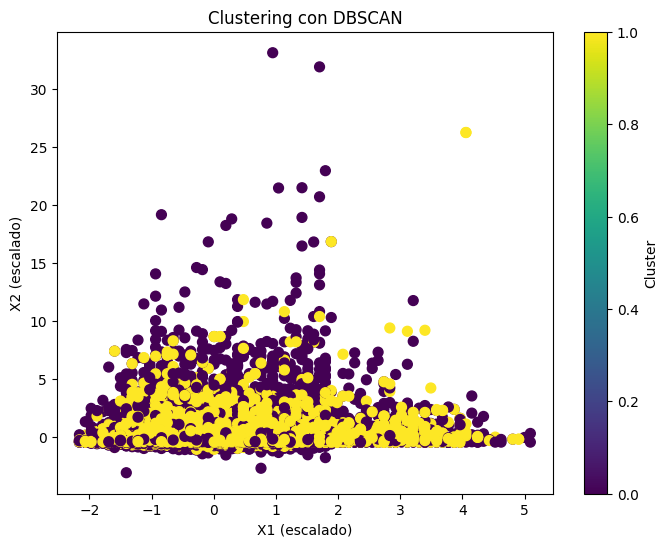

In [27]:
n_components_range = range(2, 10)
cov_type = 'full'

best_score = -1
best_params = None

for n_components in n_components_range:
    try:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
        labels = gmm.fit_predict(X_var_scaled_full)

        # Validar que hay más de un cluster
        if len(set(labels)) <= 1:
            continue

        score = silhouette_score(X_var_scaled_full, labels)
        if score > best_score:
            best_score = score
            best_params = (n_components, cov_type)
    except:
        continue  # Por si alguna combinación no converge

print(f"Mejor combinación: n_components={best_params[0]}, covariance_type='{best_params[1]}', Silhouette={best_score:.3f}")

# 4. Ajustar GMM final
best_gmm = GaussianMixture(n_components=best_params[0], covariance_type=best_params[1], random_state=42)
labels = best_gmm.fit_predict(X_var_scaled_full)

# 5. Visualizar resultados
plt.figure(figsize=(8, 6))
plt.scatter(X_var_scaled_full.iloc[:, 0], X_var_scaled_full.iloc[:, 1], c=labels, cmap='viridis', s=50)
plt.title("Clustering con DBSCAN")
plt.xlabel("X1 (escalado)")
plt.ylabel("X2 (escalado)")
plt.colorbar(label="Cluster")
plt.show()

# Decoder Encoder Cluster

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.cluster import KMeans


input_dim = X_var_scaled_full.shape[1] 
encoding_dim =  8
X_var_scaled_full = X_var_scaled_full.values.astype(np.float32)

input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(64, activation='relu')(input_layer)
encoder = layers.Dense(32, activation='relu')(encoder)
encoder = layers.Dense(32, activation='relu')(encoder)
latent = layers.Dense(encoding_dim, activation=None)(encoder)

decoder = layers.Dense(32, activation='relu')(latent)
decoder = layers.Dense(32, activation='relu')(decoder)
decoder = layers.Dense(64, activation='relu')(decoder)
output_layer = layers.Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
encoder_model = models.Model(inputs=input_layer, outputs=latent)

autoencoder.compile(optimizer='adam', loss='mse')

# --- 2. Entrenar autoencoder ---
# X_var_scaled_full: datos normalizados de entrada
autoencoder.fit(X_var_scaled_full, X_var_scaled_full, epochs=50, batch_size=256, shuffle=True)

# --- 3. Inicializar centros con KMeans en el embedding ---
latent_embeddings = encoder_model.predict(X_var_scaled_full)
k = encoding_dim  # n_clusters
kmeans = KMeans(n_clusters=k, n_init=20)
y_pred = kmeans.fit_predict(latent_embeddings)
cluster_centers = kmeans.cluster_centers_

# --- 4. Definir capa de clustering con centros fijos ---
class ClusteringLayer(layers.Layer):
    def __init__(self, n_clusters, cluster_centers, **kwargs):
        super().__init__(**kwargs)
        self.n_clusters = n_clusters
        self.cluster_centers = tf.Variable(cluster_centers, dtype=tf.float32, trainable=False)

    def call(self, inputs):
        # Student's t-distribution, medida de similitud
        q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.cluster_centers), axis=2) / 1.0))
        q = tf.transpose(tf.transpose(q) / tf.reduce_sum(q, axis=1))
        return q

# --- 5. Construir modelo DEC ---
clustering_layer = ClusteringLayer(n_clusters=k, cluster_centers=cluster_centers, name='clustering')(latent)
dec_model = models.Model(inputs=input_layer, outputs=[clustering_layer, autoencoder.output])

# --- 6. Definir función objetivo KL Divergence ---
def target_distribution(q):
    weight = q ** 2 / tf.reduce_sum(q, axis=0)
    return tf.transpose(tf.transpose(weight) / tf.reduce_sum(weight, axis=1))

# --- 7. Entrenar DEC ---
optimizer = optimizers.Adam()
loss_fn = tf.keras.losses.KLDivergence()

@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        q, x_decoded = dec_model(x, training=True)
        p = target_distribution(q)
        loss = loss_fn(p, q) + tf.reduce_mean(tf.square(x - x_decoded))  # KL + reconstrucción
    grads = tape.gradient(loss, dec_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, dec_model.trainable_weights))
    return loss

# Entrenamiento en bucle
epochs = 50
batch_size = 256
dataset = tf.data.Dataset.from_tensor_slices(X_var_scaled_full).batch(batch_size)

for epoch in range(epochs):
    for step, batch_x in enumerate(dataset):
        loss = train_step(batch_x)
    print(f"Epoch {epoch+1}/{epochs}, loss: {loss.numpy():.4f}")

# --- 8. Obtener etiquetas finales ---
q, _ = dec_model.predict(X_var_scaled_full)
y_pred_final = np.argmax(q, axis=1)


Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3010
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1824
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1529
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1483
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1385
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1480
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1342
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1395
Epoch 9/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1298
Epoch 10/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1348
Epoch 11/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1380
Epoch 12/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1296
Epoch 13/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1444
Epoch 14/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1226
Epoch 15/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

In [11]:
score = silhouette_score(latent_embeddings, y_pred_final)
print(f"Silhouette Score: {score:.4f}")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
embedding_2d = reducer.fit_transform(latent_embeddings)

# Visualizar
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y_pred_final, cmap='tab10', s=10)
plt.colorbar(label='Cluster')
plt.title('Clusters visualizados con UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()

Silhouette Score: 0.0619


In [ ]:
def distributions(df: pd.DataFrame, col: str) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    ax1.scatter(data = df, x = col, y='SalePrice', color='red')
    ax1.set_xlabel(col)
    ax1.set_ylabel('SalePrice')
    ax1.set_title(f'Scatterplot {col} vs SalePrice')
    skew_value = df[col].skew()
    ax1.annotate(f'Skew: {skew_value:.2f}', 
                 xy=(0.8, 0.9), 
                 xycoords='axes fraction', 
                 xytext=(10, 10),
                 textcoords='offset points', 
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12, color='black')

    ax2.boxplot(df[col])
    ax2.set_xlabel(col)
    ax2.set_title(f'Boxplot de {col}')
    sns.histplot(ax = ax3, data=df, x=df[col], color='red')
    ax3.set_title(f'KDE plot of {col}')
    ax3.set_xlabel(col)
    ax3.set_ylabel('Density')
    plt.tight_layout()
    plt.show()

    if col in df.select_dtypes(include=np.number).columns:
        print(f'\n The skew of {col} is {skew_value:.2f}')